In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [2]:
config = {
    "base_dir":        "/storage/vbsjjlnu/VBSjjlnu_v7/",
    "plot_config":     "FullRun2_v7",
    "cut":             "boost_sig",
    "model_version":   "v3",
}

In [3]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

import yaml
model_config_file = open(model_dir + "/model_config.yml", "r")
model_config = yaml.safe_load(model_config_file)

for key in ["samples_version", "cols"]:
    config[key] = model_config[key]

In [4]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [ ]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight"]).values
Wnn_bkg = (bkg["weight"]).values

In [7]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [8]:
scaler = pickle.load(open(f"{model_dir}/scaler_model.pkl", "rb"))
X_scaled = scaler.fit_transform(X)

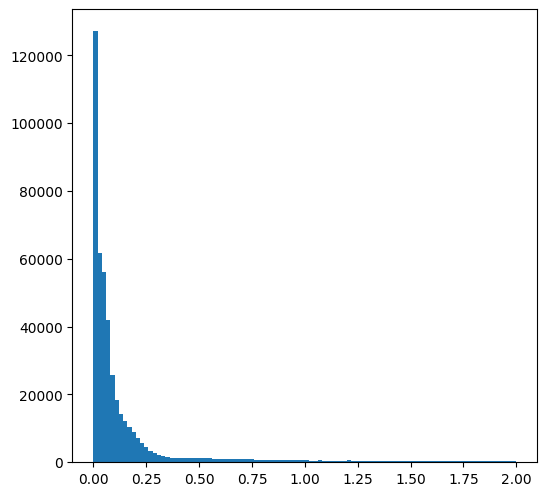

In [9]:
# _ = plt.hist(W, bins=100)
_ = plt.hist(W, bins=100, range=(0,2))

##  Balancing


In [9]:
config["test_size"] = 0.2
#config["val_size"]  = 0.5  ## test != val
config["val_size"]  = 0.0  ## test == val

X_train, X_temp, y_train, y_temp, W_train, W_temp , Wnn_train, Wnn_temp = train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"], stratify=Y)
#X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val

In [10]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_temp.shape)
#print("Testing    dataset: ", X_test.shape)
#print("Validation dataset: ", X_val.shape)

Training   dataset:  (383402, 32)
Test + Val dataset:  (95851, 32)


## SKLEARN - AVOVA F-Test

In [13]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, f_classif

import itertools

## This uses only public API, but is a real mess
#mask = [False for i in range (len(config["cols"]))]
#for varn  in range (len(config["cols"]) + 1):
#    a = SelectKBest(f_classif, k=varn)
#    a.fit(X_train, y_train)
#    mask_old = mask.copy()
#    mask = a.get_support()
#    mask_xor = [x ^ y for x,y in zip(mask, mask_old)]
#    print(varn, list(itertools.compress( config["cols"], mask_xor )))
        
## This uses a SelectKBest "private" member, but is faster and cleaner
selection = SelectKBest(f_classif, k=4)
selection.fit(X_train, y_train)
scores_df = pd.DataFrame({"score": selection.scores_, "varname": config["cols"]})


In [106]:
## visualize list of scores
#scores_df.sort_values(by=["score"], ascending=False)

<BarContainer object of 32 artists>

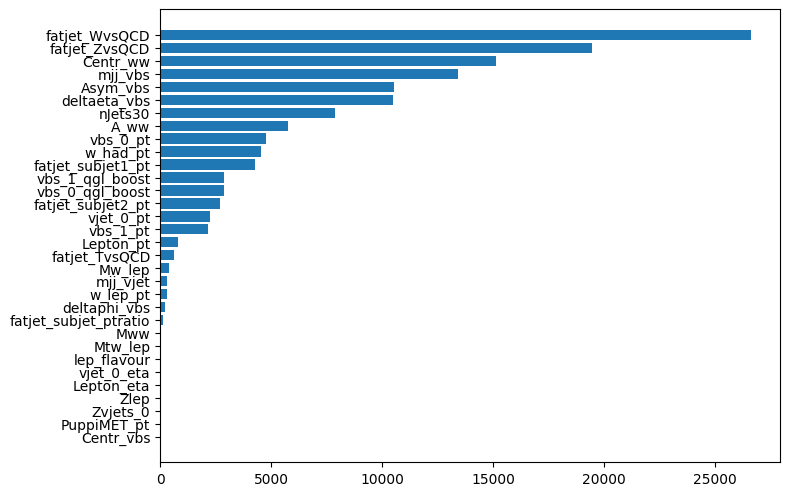

In [14]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

## visualize scores as barchart
s_df = scores_df.sort_values(by=["score"], ascending=True)
plt.barh(range(len(s_df["score"])), s_df["score"], tick_label=s_df["varname"])

## Keras model

In [11]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(model_dir, "model.h5"))

model.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 80)                2640      
_________________________________________________________________
dropout_21 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 50)                4050      
_________________________________________________________________
dropout_22 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_23 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 50)              

In [ ]:
type(model)

# SHAP

In [15]:
## https://github.com/slundberg/shap

!pip3 install --user --upgrade shap
# 0.35

     |████████████████████████████████| 327kB 4.7MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=457599 sha256=4ebf3c768b75b4b373e087e1bd9885494a1b4e0ca9644ab5743ffc0f4409bb4c
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap
  Found existing installation: shap 0.35.0
    Uninstalling shap-0.35.0:
      Successfully uninstalled shap-0.35.0
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
import shap

shap.initjs()

In [17]:
index1 = [x for x in range(len(X_train))]
X_train_pd = pd.DataFrame(X_train, index=index1, columns=config["cols"])
index2 = [x for x in range(len(X_train), len(X_train) + len(X_temp))]
X_temp_pd = pd.DataFrame(X_temp, index=index2, columns=config["cols"])

In [21]:
shap_lenght = 1000
e = shap.DeepExplainer(model, tf.convert_to_tensor(X_train_pd.iloc[:shap_lenght,:].values))

In [22]:
shap_values = e.shap_values(X_temp[:shap_lenght])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function TFDeepExplainer.phi_symbolic.<locals>.grad_graph at 0x7ff39ef46f28>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function TFDeepExplainer.phi_symbolic.<locals>.grad_graph at 0x7ff39ef46f28>. Note that functions defined in certain environments, like the interactive Python shell do not expose their

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'mean'

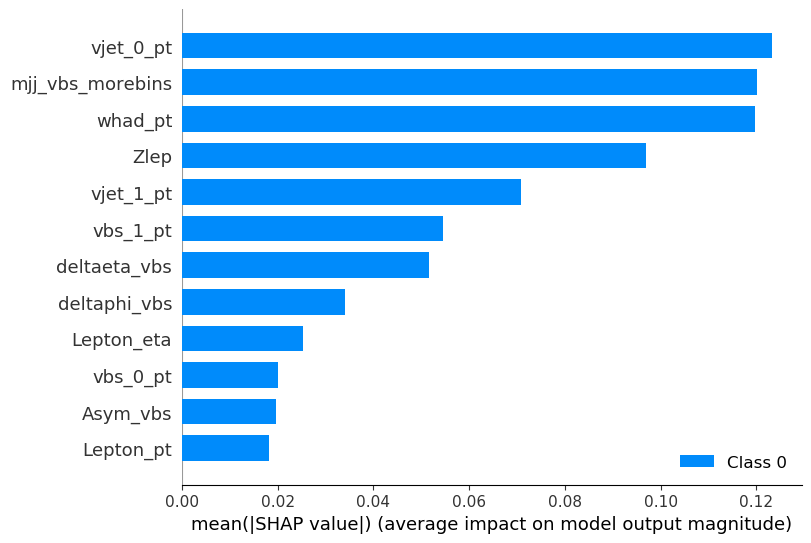

In [27]:
shap.summary_plot(shap_values, X_temp_pd.iloc[:,:], max_display=30)

In [28]:
shap_values = e.shap_values(X_temp[1000:1000+shap_lenght])

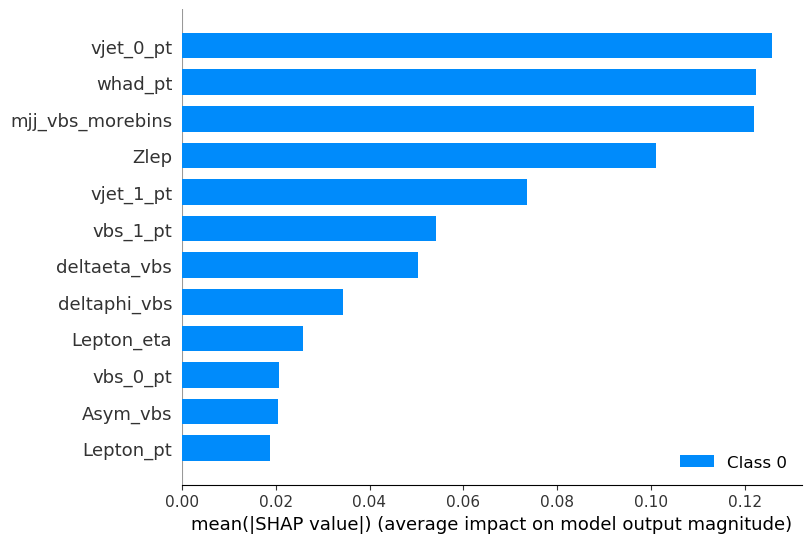

In [29]:
shap.summary_plot(shap_values, X_temp_pd.iloc[:,:], max_display=30)

In [30]:
index_event = 0
shap.force_plot(e.expected_value[0], shap_values[0][index_event], X_temp_pd.iloc[index_event,:])

In [31]:
index_event = 3

shap.force_plot(e.expected_value[0], shap_values[0][index_event], X_temp_pd.iloc[index_event,:])

In [32]:
index_event = 15

shap.force_plot(e.expected_value[0], shap_values[0][index_event], X_temp_pd.iloc[index_event,:])

In [33]:
index_event = 2

shap.force_plot(e.expected_value[0], shap_values[0][index_event], X_temp_pd.iloc[index_event,:])

In [46]:
shap.force_plot(e.expected_value, shap_values[0], X_temp_pd.iloc[:shap_lenght,:])

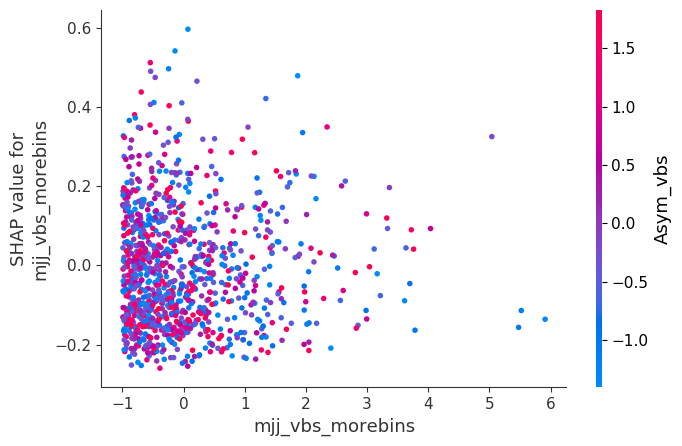

In [34]:
shap.dependence_plot("mjj_vbs_morebins", shap_values[0], X_temp_pd.iloc[:1000])

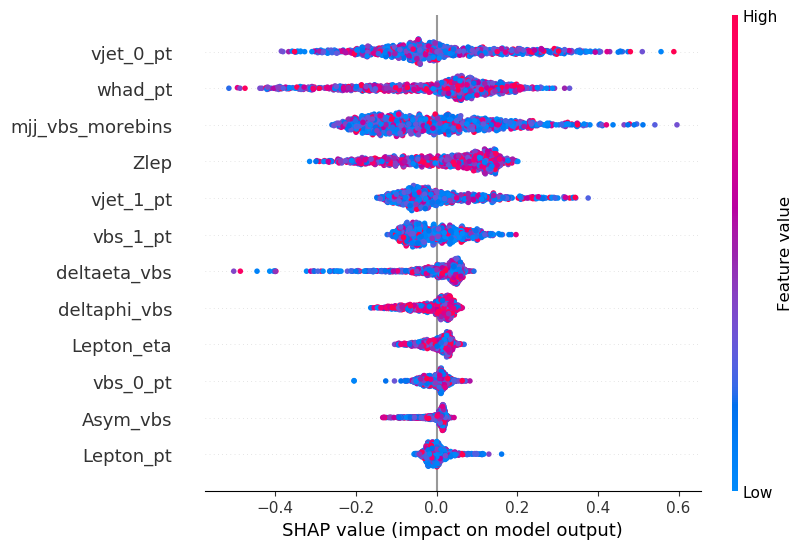

In [35]:
shap.summary_plot(shap_values[0], X_temp_pd.iloc[:1000])

In [37]:
import os

notebook_name = 'Evaluate_ANOVA_SHAP.ipynb'
file_name = 'Evaluate_ANOVA_SHAP.html'
import sys
!{sys.executable} -m jupyter nbconvert --to html $notebook_name --output /eos/home-d/dvalsecc/Code/Latinos/ML_classification/$file_name

print(os.getcwd())
print(os.listdir(os.getcwd()))
print("rsync Evaluate_ANOVA_SHAP.html lxplus.cern.ch:" + model_dir + "/Evaluate_ANOVA_SHAP.html; mv Evaluate_ANOVA_SHAP.html Evaluate_ANOVA_SHAP.html_old" )

#os.rename('Evaluate_ANOVA_SHAP.html', model_dir + "/Evaluate_ANOVA_SHAP.html")
#print(model_dir + "/Evaluate_ANOVA_SHAP.html")

[NbConvertApp] Converting notebook Evaluate_ANOVA_SHAP.ipynb to html
[NbConvertApp] Writing 2379717 bytes to /eos/home-d/dvalsecc/Code/Latinos/ML_classification/Evaluate_ANOVA_SHAP.html
/eos/home-d/dvalsecc/Code/Latinos/ML_classification
['.git', '.gitignore', '.sys.v#.BinningStudies.ipynb', '.sys.v#.Correlations.ipynb', '.sys.v#.DataPreparation.ipynb', '.sys.v#.Evaluate_ANOVA_SHAP.ipynb', '.sys.v#.Training_bdt.ipynb', '.sys.v#.Training_v0-Copy1.ipynb', '.sys.v#.Training_v0.ipynb', '.sys.v#.Training_v1.ipynb', '.sys.v#.Training_v2.ipynb', 'BinningStudies.ipynb', 'Correlations.ipynb', 'DataPreparation.ipynb', 'Evaluate_ANOVA_SHAP.html', 'Evaluate_ANOVA_SHAP.html_old', 'Evaluate_ANOVA_SHAP.ipynb', 'ScoresCorrelations.ipynb', 'Training_bayesianopt.ipynb', 'Training_bdt.ipynb', 'Training_v0.ipynb', 'Training_v1.ipynb', 'Training_v2.ipynb', '__pycache__', 'cumulative_signal_boost_v5.root', 'cumulative_signal_resolved_v29.root', 'dnn_bayesian_opt.py', 'dnn_model_generator.py', 'dnn_models.py

### Evaluation

>>> Computing AUC...


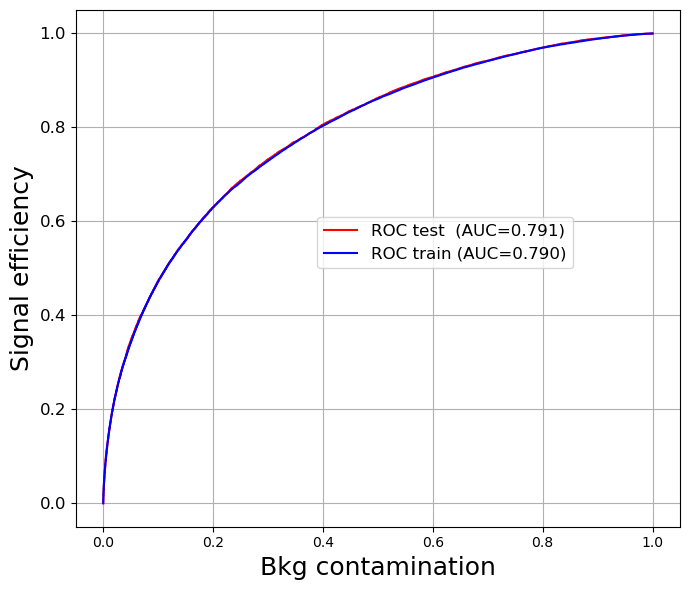

In [18]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

X_test = X_temp
W_test = W_temp
y_test = y_temp
pred_test  = model.predict(X_test,  batch_size=2048)
pred_train = model.predict(X_train, batch_size=2048)
auc_w_test  = roc_auc_score(y_test, pred_test,  sample_weight=W_test)
auc_w_train = roc_auc_score(y_train,pred_train, sample_weight=W_train)
fpW_test,  tpW_test,  thW_test  = roc_curve(y_test,  pred_test , sample_weight=W_test)
fpW_train, tpW_train, thW_train = roc_curve(y_train, pred_train, sample_weight=W_train)
#print("AUC score: " + str(auc))

fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

# ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
ax1.plot(fpW_test,  tpW_test,  label=f"ROC test  (AUC={auc_w_test:.3f})", color="red")
ax1.plot(fpW_train, tpW_train, label=f"ROC train (AUC={auc_w_train:.3f})", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()

In [20]:
#r = model.evaluate_generator(training_generator, steps=1000)
r = model.evaluate_generator(validation_generator, steps=1000)


NameError: name 'validation_generator' is not defined

NameError: name 'history' is not defined

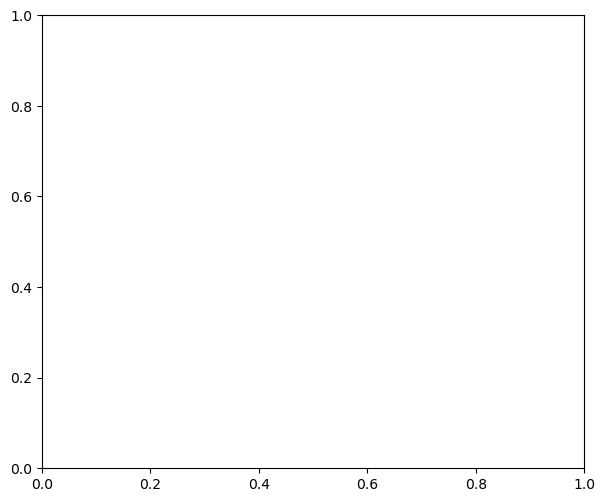

In [19]:
fig, ax = plt.subplots(figsize=(7,6), dpi=100)
ax.plot(history.epoch, history.history["val_loss"], label="validation loss")
ax.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

# Some DNN distribution plots

In [12]:
bkg["y"] = model.predict(scaler.transform(bkg[config["cols"]].values), batch_size=2048)

In [13]:
signal["y"] = model.predict(scaler.transform(signal[config["cols"]].values), batch_size=2048)

In [23]:
wjets = bkg[bkg["sample_name"] == "Wjets"]
top = bkg[bkg["sample_name"] == "top"]
dy = bkg[bkg["sample_name"] == "DY"]

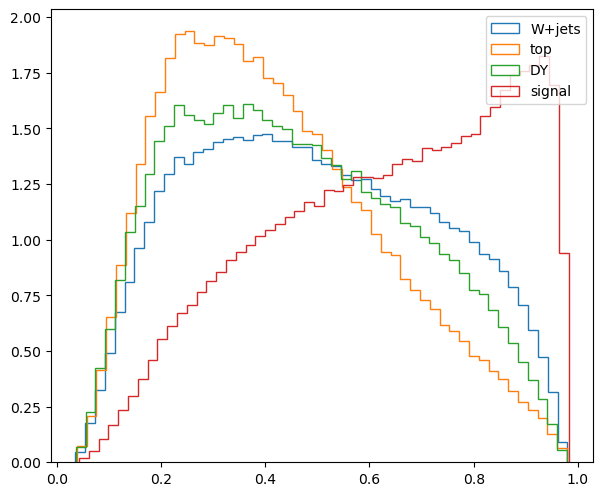

In [24]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(bkg[bkg["sample_name"] == "Wjets"]["y"], bins=50, density=True, label="W+jets", histtype="step")
plt.hist(bkg[bkg["sample_name"] == "top"]["y"],   bins=50, density=True, label="top",    histtype="step")
plt.hist(bkg[bkg["sample_name"] == "DY"]["y"],    bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

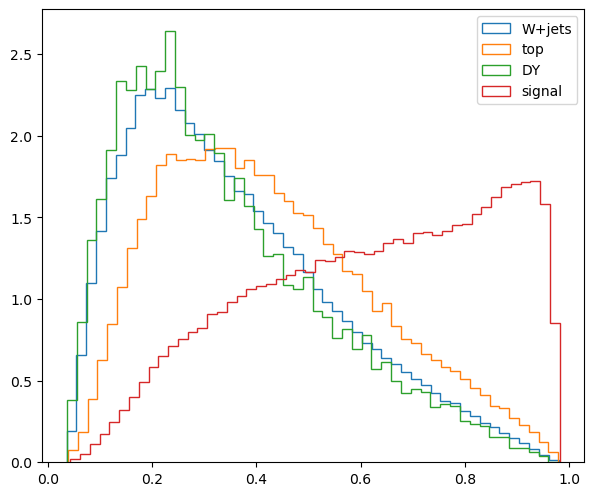

In [25]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(wjets["y"], weights=wjets.weight_norm, bins=50, density=True, label="W+jets", histtype="step")
plt.hist(top["y"],   weights=top.weight_norm,  bins=50, density=True, label="top",    histtype="step")
plt.hist(dy["y"],    weights=dy.weight_norm,  bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], weights=signal.weight_norm, bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

Text(0, 0.5, 'DeltaEta VBS')

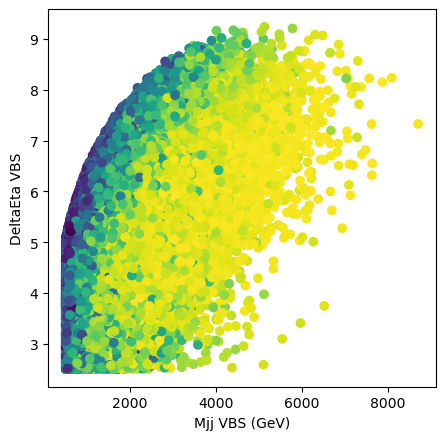

In [35]:
fig = plt.figure(figsize=(5,5))
plt.scatter(signal.mjj_vbs_morebins, signal.deltaeta_vbs, c=signal.y)
plt.xlabel("Mjj VBS (GeV)")
plt.ylabel("DeltaEta VBS")

In [39]:
import seaborn as sns
sns.set(style="white")

/usr/local/bin/start_ipykernel.py:7: RuntimeWarning: invalid value encountered in true_divide


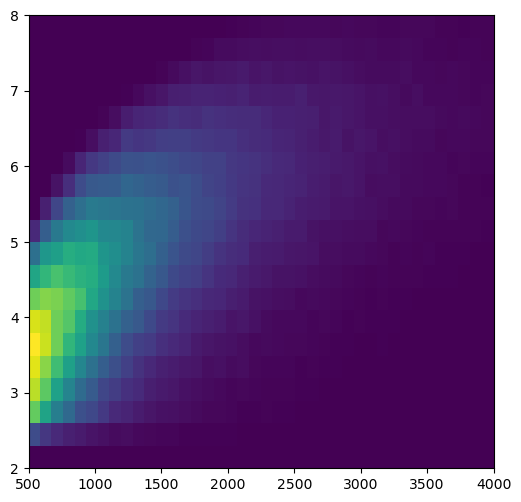

In [52]:
yrange= [2,8]
xrange= [500,4000]

b = plt.hist2d(signal.mjj_vbs_morebins,signal.deltaeta_vbs, range=[xrange, yrange], weights= signal.y, bins=(40,20), cmap="viridis")
a = plt.hist2d(signal.mjj_vbs_morebins,signal.deltaeta_vbs,range=[xrange, yrange], bins=(40,20), cmap="viridis")

c = b[0] / a[0]


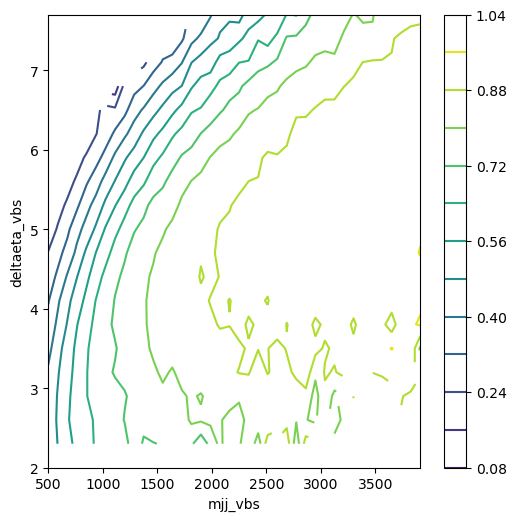

In [61]:
plt.contour(a[1][:-1],a[2][:-1], c.T, levels=10, vmax=1, vmin=0)
plt.xlabel("mjj_vbs")
plt.ylabel("deltaeta_vbs")
plt.colorbar()